# 

# GIS (intro)

## What is GIS?

GIS stands for Geographic Information System. It is a system designed to capture, store, manipulate, analyze, manage, and present spatial or geographic data. In other words, GIS is used to create maps and analyze spatial data for a wide range of applications.

In this note, we'll cover some basic GIS concepts and tools that are useful for atmospheric science research.

## What we'll cover
- Define a bounding box of a map, using [geojson.io](http://geojson.io/)
- Download atmospheric data using [earthkit](https://earthkit.readthedocs.io/en/latest/index.html)
- Plot bbox and atmosphere data on a map using [geopandas](https://geopandas.org/) and [folium](https://python-visualization.github.io/folium/)
- Applying standardized partitioning of globe into regions using [regionmask](https://regionmask.readthedocs.io/en/stable/)
- Analyze data per region using [xarray](http://xarray.pydata.org/en/stable/)

In [28]:
!uv pip install -r ../requirements.txt

from shapely.geometry import box
import earthkit
import folium
import geopandas as gpd
import numpy as np
import xarray as xr



Using Python 3.12.4 environment at: /Users/per.morten.halvorsen@schibsted.com/personal/earth-ml/.venv
Audited 5 packages in 12ms


# Getting started

## Polygon

Used https://geojson.io/ to help defined polygon coordinates. 

[Example](https://geojson.io/#new&map=1.78/17.5/-136.2)
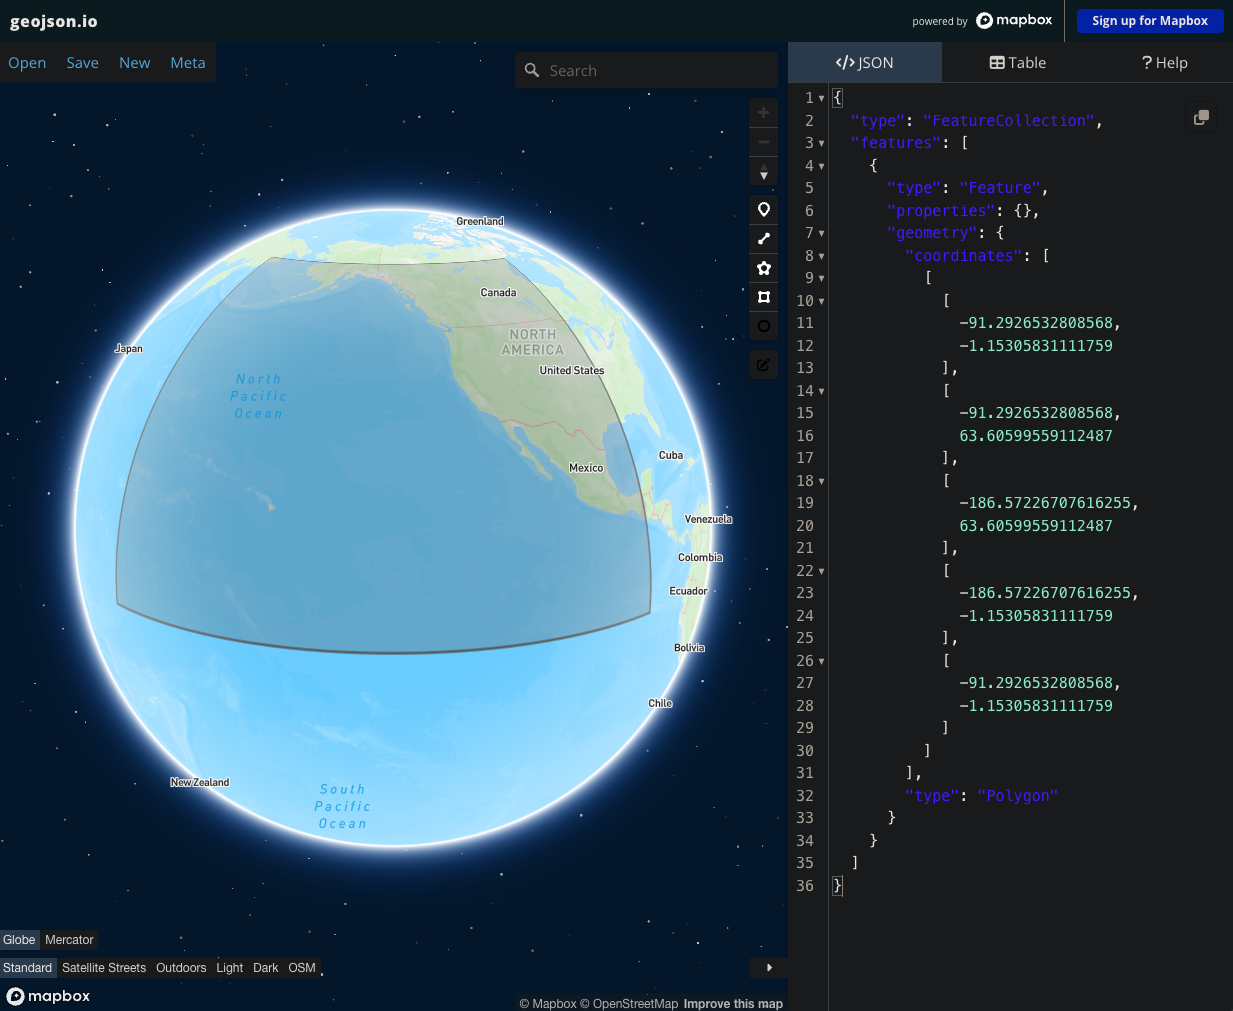

In [16]:
# Use the coordinates of the polygon created as a geometry feature
polygon =   [
    [
      -91.2926532808568,
      -1.15305831111759
    ],
    [
      -91.2926532808568,
      63.60599559112487
    ],
    [
      -186.57226707616255,
      63.60599559112487
    ],
    [
      -186.57226707616255,
      -1.15305831111759
    ],
    [
      -91.2926532808568,
      -1.15305831111759
    ]
]

## Coordinate utils 

Some helper functions to convert coordinates to bounding box and vice versa.


In [31]:
def nwse_to_latlon(n, w, s, e):
    """
    Convert north-west-south-east coordinates to latitude-longitude coordinates.
    """
    lat = (n + s) / 2
    lon = (w + e) / 2
    return lat, lon


def latlon_to_nwse(lat: tuple, lon: tuple):
    """
    Convert latitude-longitude coordinates to north-west-south-east coordinates.

    :params:
        lat: tuple, latitude
        lon: tuple, longitude
    """
    n = lat[0]
    s = lat[1]
    w = lon[0]
    e = lon[1]
    return n, w, s, e


def get_bbox(lat, lon, radius):
    """
    Get bounding box from latitude, longitude and radius.
    """
    n = lat + radius
    s = lat - radius
    w = lon - radius
    e = lon + radius
    return n, w, s, e


def polygon_to_nwse(poly):
    """
    Get bounding box from polygon.
    """
    lats = [p[1] for p in poly]
    lons = [p[0] for p in poly]
    n = max(lats)
    s = min(lats)
    w = min(lons)
    e = max(lons)
    return n, w, s, e


In [32]:

n,w,s,e = polygon_to_nwse(polygon)

lat, lon = nwse_to_latlon(n,w,s,e)

print("NWSE:", n,w,s,e)
print("LAT:", lat, "LON:", lon)

NWSE: 63.60599559112487 -186.57226707616255 -1.15305831111759 -91.2926532808568
LAT: 31.226468640003638 LON: -138.93246017850967


# Atmospheric data w/ [earthkit](https://earthkit.readthedocs.io/en/latest/index.html)

## API setup

In order to use this package, we needed to create an account to generate an API key, using the following link:
https://cds.climate.copernicus.eu/profile 



You can browse the different datasets available in the [Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/datasets/), where you'll need to request access to each dataset you'll like to access. In this note, we'll use the [CAMS global reanalysis (EAC4)](https://ads.atmosphere.copernicus.eu/datasets/cams-global-reanalysis-eac4?tab=download) data.


When running the below code for the first time, you'll likely be asked to provide an API url and key. The key is found in your profile. For the athmosperic data, the endpoint is:
 `https://ads.atmosphere.copernicus.eu/api/`. 

## Download data

In [ ]:
coords = polygon_to_nwse(polygon)


ds = earthkit.data.from_source(
    "ads",
    "cams-global-reanalysis-eac4",
    variable=["particulate_matter_10um", "particulate_matter_1um", "2m_temperature", "mean_sea_level_pressure", "total_column_carbon_monoxide"],
    area=[*coords], # N, W, S, E
    date="2016-12-21",
    time="12:00",
)

ds

2024-12-22 21:27:56,548 INFO [2024-09-26T00:00:00] **Welcome to the New Atmosphere Data Store (ADS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new ADS for the benefit of everyone. Thank you.
2024-12-22 21:27:56,549 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-22 21:27:56,674 INFO [2024-09-26T00:00:00] **Welcome to the New Atmosphere Data Store (ADS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new ADS for the benefit of everyone. Thank you.
2024-12-

GRIBReader(/var/folders/9t/2ktxww317sjf49by2n8qnpb80000gp/T/tmp1f1qgzfk/ads-retriever-0cd1fb45eb685f7b4901e1c3a1dd9892d3d8ebc143fa45b5b93c297e3a2a4dc2.cache)

### Load GRIB as xarray


In [29]:
ds_xr = xr.open_dataset(ds.path, engine='cfgrib')
ds_xr

<xarray.Dataset> Size: 224kB
Dimensions:     (latitude: 87, longitude: 128)
Coordinates:
    number      int64 8B ...
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 696B 63.35 62.6 61.85 ... 0.347 -0.403 -1.154
  * longitude   (longitude) float64 1kB 173.4 174.2 174.9 ... 267.2 267.9 268.7
    valid_time  datetime64[ns] 8B ...
Data variables:
    pm10        (latitude, longitude) float32 45kB ...
    pm1         (latitude, longitude) float32 45kB ...
    t2m         (latitude, longitude) float32 45kB ...
    msl         (latitude, longitude) float32 45kB ...
    tcco        (latitude, longitude) float32 45kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-22T21:46 GRIB to CDM+CF via cfgrib-0.9.1...

# Plot geo-data w/ [geopandas](https://geopandas.org/) and [folium](https://python-visualization.github.io/folium/)

## Bounding box

In [33]:
coords = polygon_to_nwse(polygon)


def draw_map_bbox(coords):
    n, w, s, e = coords
    lat, lon = nwse_to_latlon(n, w, s, e)
    # Create a GeoDataFrame with the bounding box (w, s, e, n)
    bbox = gpd.GeoDataFrame({'geometry': [box(w, s, e, n)]})

    # Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
    bbox = bbox.set_crs(epsg=4326)

    # Create a folium map centered around the bounding box
    base_map = folium.Map(
        location=[
            lat, 
            lon
        ], 
        zoom_start=3
    )

    # Add the bounding box to the map
    folium.GeoJson(bbox).add_to(base_map)

    # Display the map
    return base_map


base_map = draw_map_bbox(coords)

# Display the map
base_map

## Climate data

In [51]:
def xr_to_nwse(xr):
    """
    Get north-west-south-east coordinates from xarray dataset.
    """
    lats = xr.latitude.values
    lons = xr.longitude.values
    n = float(max(lats))
    s = float(min(lats))
    w = float(min(lons))
    e = float(max(lons))
    return n, w, s, e

xr_to_nwse(ds_xr)

(63.347, 173.427, -1.154, 268.678)

### Particulate matter 10m (pm10)


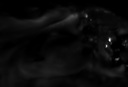

In [70]:
def draw_map_data(xr, variable, opacity=1.0):
    coords = xr_to_nwse(xr)

    map = draw_map_bbox(coords)

    data = xr[variable].values

    # Create a folium raster layer for pm10 data
    folium.raster_layers.ImageOverlay(
        image=data,
        bounds=[
            [coords[2], coords[1]],  # n, w
            [coords[0], coords[3]]   # s, e
        ],
        # colormap=lambda x: (1, 0, 0, x),  # Red colormap
        opacity=opacity
    ).add_to(map)

    return map


draw_map_data(ds_xr, "pm10", 0.7)


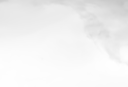

In [68]:

draw_map_data(ds_xr, "t2m", 0.7)


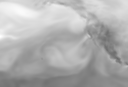

In [67]:
draw_map_data(ds_xr, "tcco", 0.7)

## Draw map for new polygon

## More plotting 

But with matplotlib

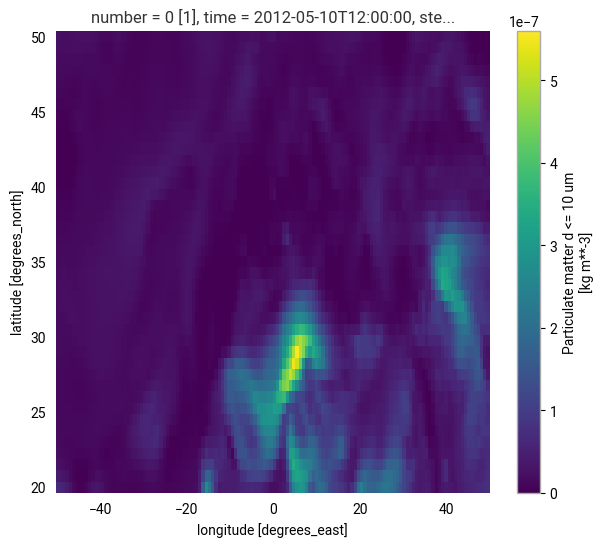

In [29]:
ds_xr["pm10"].plot()

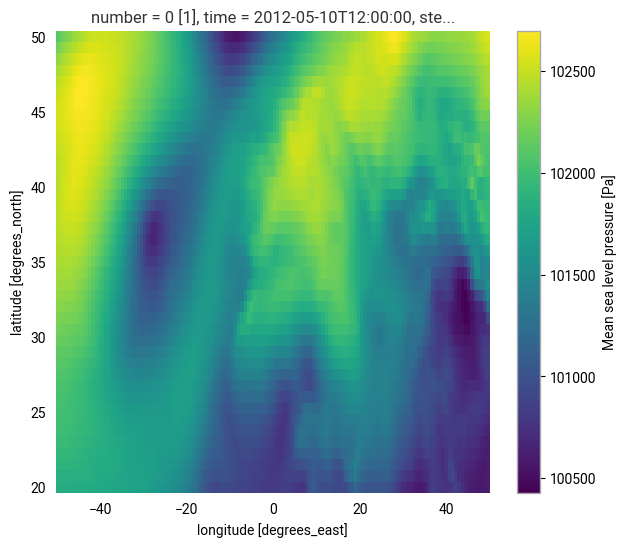

In [30]:
ds_xr["msl"].plot()

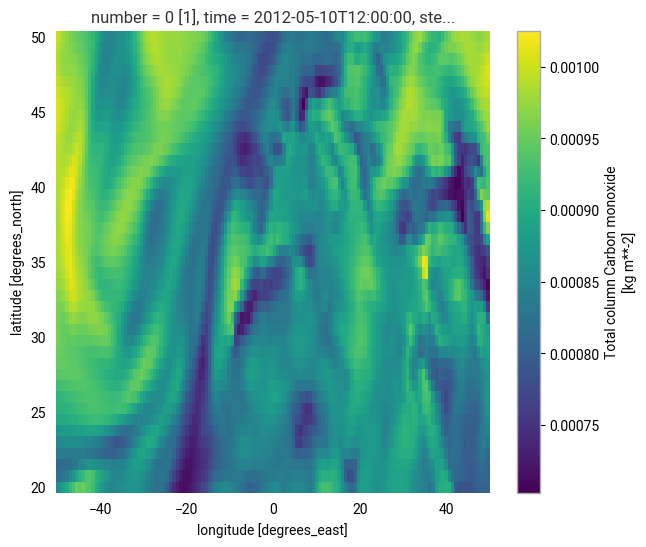

In [32]:
ds_xr["tcco"].plot()

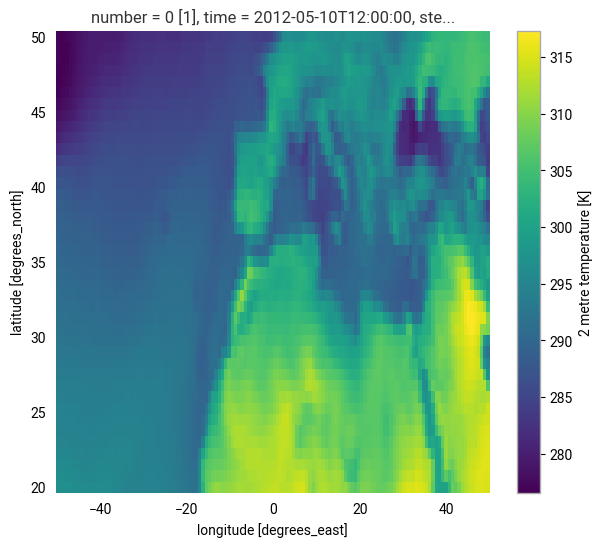

In [33]:
ds_xr["t2m"].plot()

# [regionmask](https://regionmask.readthedocs.io/en/stable/)

We'll use a scientific region defined in regionmask's documentation: https://regionmask.readthedocs.io/en/stable/defined_scientific.html

In [71]:
import regionmask

In [72]:
regionmask.defined_regions.ar6.all

<regionmask.Regions 'AR6 reference regions'>
Source:   Iturbide et al., 2020 (ESSD)
overlap:  False

Regions:
 0 GIC      Greenland/Iceland
 1 NWN      N.W.North-America
 2 NEN      N.E.North-America
 3 WNA        W.North-America
 4 CNA        C.North-America
..  ..                    ...
53 ARS            Arabian-Sea
54 BOB          Bay-of-Bengal
55 EIO Equatorial.Indic-Ocean
56 SIO          S.Indic-Ocean
57 SOO         Southern-Ocean

[58 regions]

<GeoAxes: >

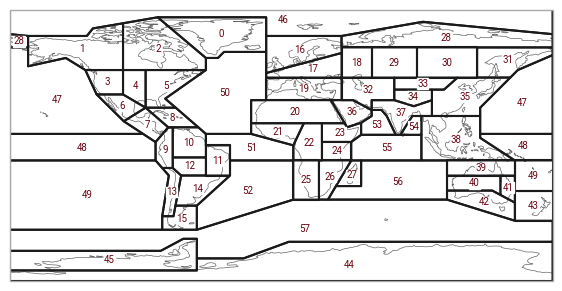

In [73]:
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

regionmask.defined_regions.ar6.all.plot(
    text_kws=text_kws, label_multipolygon="all"
)

In [77]:
for region in regionmask.defined_regions.ar6.all:
    print(region)
    break 

region

<regionmask._OneRegion: Greenland/Iceland (GIC / 0)>


<regionmask._OneRegion: Greenland/Iceland (GIC / 0)>

In [78]:
region.coords

array([[-10.        ,  62.        ],
       [-10.4375    ,  62.        ],
       [-10.875     ,  62.        ],
       [-11.3125    ,  62.        ],
       [-11.75      ,  62.        ],
       [-12.1875    ,  62.        ],
       [-12.625     ,  62.        ],
       [-13.0625    ,  62.        ],
       [-13.5       ,  62.        ],
       [-13.9375    ,  62.        ],
       [-14.375     ,  62.        ],
       [-14.8125    ,  62.        ],
       [-15.25      ,  62.        ],
       [-15.6875    ,  62.        ],
       [-16.125     ,  62.        ],
       [-16.5625    ,  62.        ],
       [-17.        ,  62.        ],
       [-17.4375    ,  62.        ],
       [-17.875     ,  62.        ],
       [-18.3125    ,  62.        ],
       [-18.75      ,  62.        ],
       [-19.1875    ,  62.        ],
       [-19.625     ,  62.        ],
       [-20.0625    ,  62.        ],
       [-20.5       ,  62.        ],
       [-20.9375    ,  62.        ],
       [-21.375     ,  62.        ],
 

In [79]:
region.bounds

(-82.0, 58.0, -10.0, 85.0)

In [81]:
region.polygon.bounds

(-82.0, 58.0, -10.0, 85.0)

In [84]:
polygon_to_nwse(region.polygon.exterior.coords)

(85.0, -82.0, 58.0, -10.0)


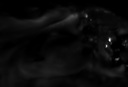


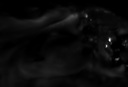


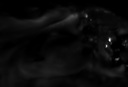


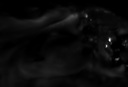


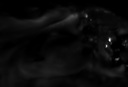


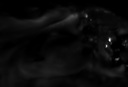


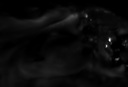


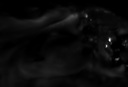


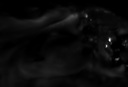


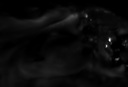


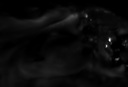


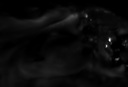


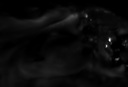


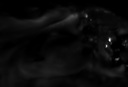


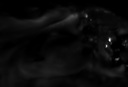


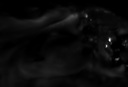


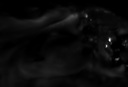


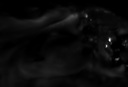


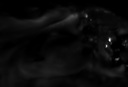


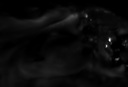


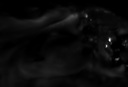


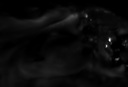


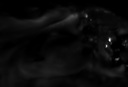


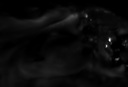


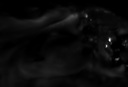


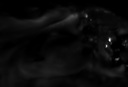


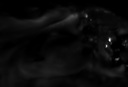


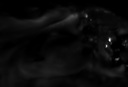

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [ ]:
for region in regionmask.defined_regions.ar6.all:
    region_coords = polygon_to_nwse(region.polygon.exterior.coords)
    region_map = draw_map_bbox(region_coords)
    
    for variable in ds_xr.data_vars:
        map_with_data = draw_map_data(ds_xr, variable, 0.7)
        display(map_with_data)
    break

AttributeError: '_OneRegion' object has no attribute 'geometry'

# Data per region